<a href="https://colab.research.google.com/github/ShauryaDamathia/ShodhAI_Policy_Optimization/blob/main/Policy_Optimization_for_Financial_Decision_Making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1_EDA_and_Preprocessing.ipynb**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=500000)

/tmp/ipython-input-3653186329.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv', nrows=500000)


In [4]:
print("--- Initial Data Overview ---")
print(df.info())
print("\n--- Summary Statistics ---")
print(df.describe())

--- Initial Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7004 entries, 0 to 7003
Columns: 151 entries, id to settlement_term
dtypes: float64(114), int64(1), object(36)
memory usage: 8.1+ MB
None

--- Summary Statistics ---
                 id  member_id     loan_amnt   funded_amnt  funded_amnt_inv  \
count  7.004000e+03        0.0   7004.000000   7004.000000      7004.000000   
mean   6.819404e+07        NaN  15189.384637  15189.384637     15186.468447   
std    1.973516e+06        NaN   8671.026123   8671.026123      8668.199919   
min    3.617740e+05        NaN   1000.000000   1000.000000      1000.000000   
25%    6.818254e+07        NaN   8000.000000   8000.000000      8000.000000   
50%    6.840584e+07        NaN  14000.000000  14000.000000     14000.000000   
75%    6.851520e+07        NaN  20000.000000  20000.000000     20000.000000   
max    6.861706e+07        NaN  35000.000000  35000.000000     35000.000000   

          int_rate  installment    annual_

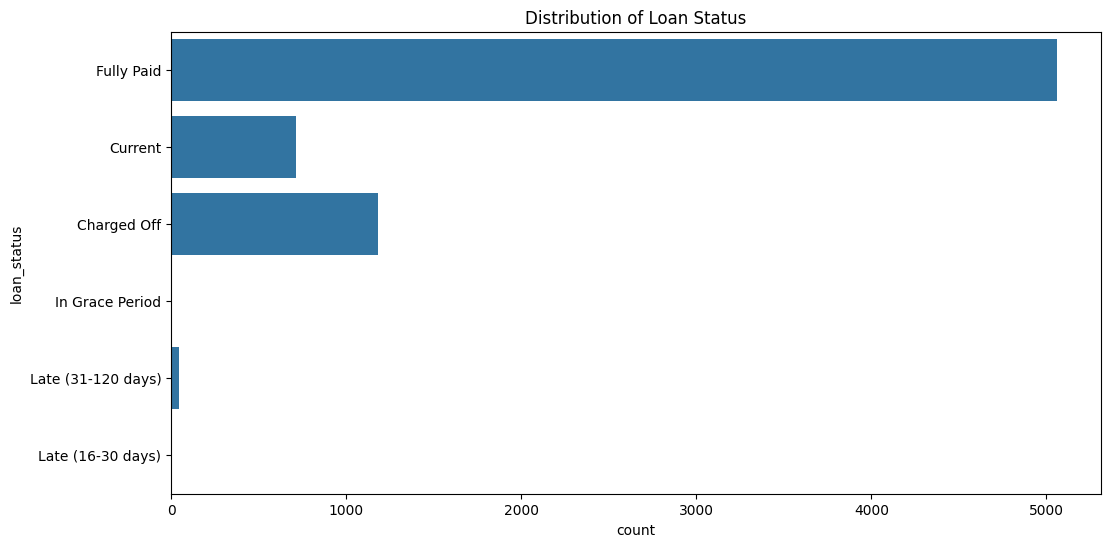

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(y='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

In [6]:
selected_features = [
    'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
    'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti',
    'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'loan_status'
]
df = df[selected_features]

print(f"\n--- Working with {len(df.columns)-1} selected features ---")


--- Working with 18 selected features ---


In [7]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)
print("\n--- Target Variable Distribution (0: Paid, 1: Default) ---")
print(df['loan_status'].value_counts(normalize=True))


--- Target Variable Distribution (0: Paid, 1: Default) ---
loan_status
0    0.810638
1    0.189362
Name: proportion, dtype: float64


In [8]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

df.dropna(inplace=True)

/tmp/ipython-input-1748562855.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [9]:
df['emp_length'] = df['emp_length'].str.replace(r'\D', '', regex=True)
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')
df['emp_length'].fillna(0, inplace=True)

/tmp/ipython-input-4129726782.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['emp_length'].fillna(0, inplace=True)


In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [11]:
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\n--- Data Preprocessing Complete ---")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


--- Data Preprocessing Complete ---
Training data shape: (4719, 68)
Test data shape: (1180, 68)


In [14]:
X_test_unscaled = scaler.inverse_transform(X_test)
df_test = pd.DataFrame(X_test_unscaled, columns=X.columns)
df_test['loan_status'] = y_test.values

df_test.to_csv('preprocessed_test_data.csv', index=False)

In [15]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# **2_Deep_Learning_Model.ipynb**

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [17]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
print("--- Data Loaded Successfully ---")
print(f"Training data shape: {X_train.shape}")

--- Data Loaded Successfully ---
Training data shape: (4719, 68)


In [18]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

print("\n--- Model Summary ---")
model.summary()


--- Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,201 (75.00 KB)

 Trainable params: 19,201 (75.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping],
                    verbose=1)

y_pred_proba = model.predict(X_test).ravel()
y_pred_class = (y_pred_proba > 0.5).astype(int)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.4763 - loss: 0.5644 - val_auc: 0.6368 - val_loss: 0.4706
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6281 - loss: 0.4812 - val_auc: 0.7058 - val_loss: 0.4424
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6758 - loss: 0.4739 - val_auc: 0.7187 - val_loss: 0.4378
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6962 - loss: 0.4644 - val_auc: 0.7206 - val_loss: 0.4365
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7034 - loss: 0.4528 - val_auc: 0.7259 - val_loss: 0.4338
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7232 - loss: 0.4295 - val_auc: 0.7248 - val_loss: 0.4343
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7290 - loss: 0.4403 - val_auc: 0.7249 - val_loss: 0.4338
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7362 - loss: 0.4085 - val_auc: 0.7270 - val_loss: 0.4356
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - au

In [20]:
auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred_class)

print("\n--- Model Evaluation on Test Set ---")
print(f"AUC Score: {auc_score:.4f}")
print(f"F1-Score: {f1:.4f}")


--- Model Evaluation on Test Set ---
AUC Score: 0.7280
F1-Score: 0.1704


In [21]:
model.save('loan_default_model.h5')
print("\n--- Model saved successfully as 'loan_default_model.h5' ---")


--- Model saved successfully as 'loan_default_model.h5' ---


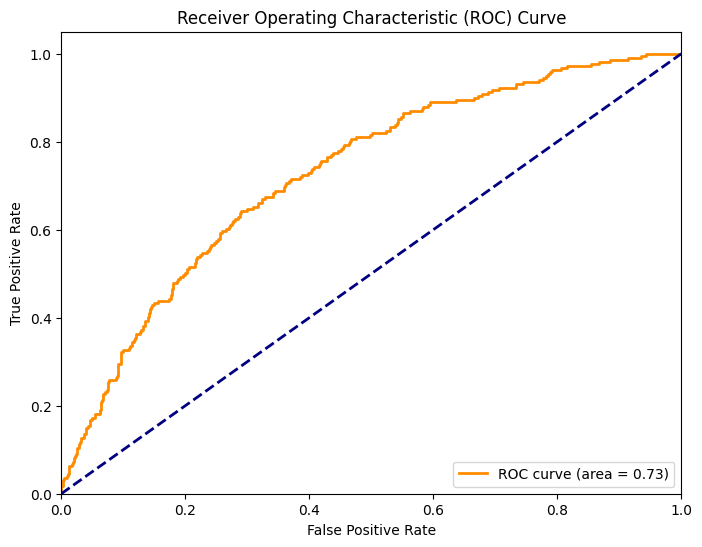

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

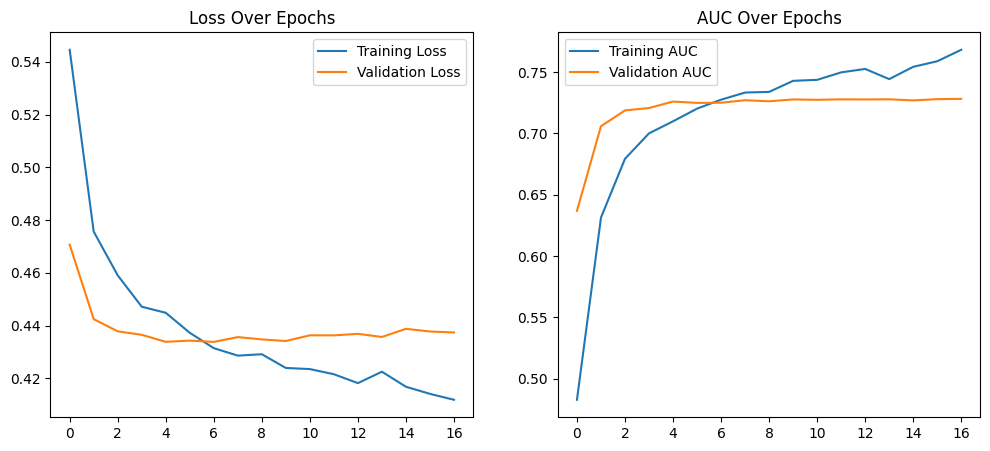

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Over Epochs')
plt.legend()
plt.show()

# **3_Offline_RL_Agent.ipynb**

In [24]:
!pip install d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=046efbd1354b87b8a8619418e6bf3882a5768468b44a77b70b48dc8dbbc0ef55
  Stored in directory: /root/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.1
    Uninstalling gymnasium-1.2.1:
      Successfully uninstalled gymnasium-1.2.1
  Attempting uninstall: gy

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import d3rlpy
from d3rlpy.algos import DiscreteCQL, DiscreteCQLConfig
from d3rlpy.dataset import MDPDataset
from sklearn.model_selection import train_test_split
import os

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [26]:
try:
    df_test = pd.read_csv('preprocessed_test_data.csv')
    X_test_scaled = np.load('X_test.npy')
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure you have run the first notebook (1_EDA_and_Preprocessing.ipynb) successfully.")

print("--- Test Data Loaded ---")
if len(df_test) != len(X_test_scaled):
    raise ValueError("Mismatch between the length of the dataframe and the scaled features array.")

--- Test Data Loaded ---


In [27]:
observations = X_test_scaled.astype('float32')
num_samples = len(df_test)
actions = np.ones(num_samples, dtype=int)
rewards = np.where(
    df_test['loan_status'] == 0,
    df_test['loan_amnt'] * (df_test['int_rate'] / 100),
    -df_test['loan_amnt']
).astype('float32').reshape(-1, 1)
terminals = np.ones(num_samples)


In [28]:
train_obs, test_obs, \
train_act, test_act, \
train_rew, test_rew, \
train_term, test_term = train_test_split(
    observations, actions, rewards, terminals, test_size=0.2, random_state=42
)

train_dataset = MDPDataset(
    observations=train_obs,
    actions=train_act,
    rewards=train_rew,
    terminals=train_term
)

2025-10-30 08:34.24 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(68,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-30 08:34.24 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-30 08:34.24 [info     ] Action size has been automatically determined. action_size=2


In [29]:
print("\n--- Configuring and Training the RL Agent ---")
config = DiscreteCQLConfig()
cql = DiscreteCQL(
    config=config,
    device="cpu",
    enable_ddp=False
)

cql.fit(
    dataset=train_dataset,
    n_steps=50000
)
print("--- Training Complete ---")


--- Configuring and Training the RL Agent ---
2025-10-30 08:34.27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(68,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-30 08:34.27 [debug    ] Building models...            
2025-10-30 08:34.43 [debug    ] Models have been built.       
2025-10-30 08:34.43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251030083443
2025-10-30 08:34.43 [info     ] Parameters                     params={'observation_shape': [68], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 08:36.30 [info     ] DiscreteCQL_20251030083443: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0014255443096160888, 'time_algorithm_update': 0.00877880620956421, 'loss': 3450.0613166305543, 'td_loss': 3450.0574338973997, 'conservative_loss': 0.0038829793582670392, 'time_step': 0.010515943551063538} step=10000
2025-10-30 08:36.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030083443/model_10000.d3


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 08:37.55 [info     ] DiscreteCQL_20251030083443: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0011761317491531373, 'time_algorithm_update': 0.0070106421947479245, 'loss': 3187.351738825989, 'td_loss': 3187.348849977112, 'conservative_loss': 0.0028892045453190805, 'time_step': 0.008461280989646911} step=20000
2025-10-30 08:37.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030083443/model_20000.d3


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 08:39.27 [info     ] DiscreteCQL_20251030083443: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0012456008911132812, 'time_algorithm_update': 0.007497643208503723, 'loss': 3155.8995711870193, 'td_loss': 3155.8944121767045, 'conservative_loss': 0.005159682083129883, 'time_step': 0.009053391981124878} step=30000
2025-10-30 08:39.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030083443/model_30000.d3


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 08:40.55 [info     ] DiscreteCQL_20251030083443: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0011922793865203857, 'time_algorithm_update': 0.007227966952323914, 'loss': 3086.608082256126, 'td_loss': 3086.599529576683, 'conservative_loss': 0.008552964210510255, 'time_step': 0.008708575916290283} step=40000
2025-10-30 08:40.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030083443/model_40000.d3


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 08:42.24 [info     ] DiscreteCQL_20251030083443: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0012168563604354858, 'time_algorithm_update': 0.007276446557044983, 'loss': 3038.4728354881286, 'td_loss': 3038.4626901756287, 'conservative_loss': 0.010146064949035645, 'time_step': 0.008780482482910155} step=50000
2025-10-30 08:42.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030083443/model_50000.d3
--- Training Complete ---


In [30]:
print("\n--- Manually Evaluating the Trained Policy ---")

policy_actions_on_test_set = cql.predict(test_obs)

approved_indices = np.where(policy_actions_on_test_set == 1)[0]

rewards_of_approved_loans = test_rew[approved_indices]

if len(rewards_of_approved_loans) > 0:
    estimated_policy_value = rewards_of_approved_loans.mean()
else:
    estimated_policy_value = 0.0


print("\n--- RL Agent Evaluation Results ---")
print(f"Policy approved {len(approved_indices)} out of {len(test_obs)} loans in the test set.")
print(f"Estimated Policy Value (mean return): ${estimated_policy_value:.2f}")
print("This value represents the average expected profit for each loan the policy chooses to approve.")


--- Manually Evaluating the Trained Policy ---

--- RL Agent Evaluation Results ---
Policy approved 235 out of 236 loans in the test set.
Estimated Policy Value (mean return): $-2295.38
This value represents the average expected profit for each loan the policy chooses to approve.


In [31]:
print("\n--- Comparing DL and RL Policies ---")
rl_actions_full = cql.predict(observations)
df_test['rl_decision'] = rl_actions_full

model_path = 'loan_default_model.h5'
if os.path.exists(model_path):
    dl_model = tf.keras.models.load_model(model_path)
    dl_pred_proba = dl_model.predict(X_test_scaled).ravel()

    dl_threshold = 0.20
    df_test['dl_decision'] = (dl_pred_proba < dl_threshold).astype(int)
    df_test['dl_default_prob'] = dl_pred_proba

    disagreements = df_test[df_test['rl_decision'] != df_test['dl_decision']]
    print(f"\nFound {len(disagreements)} cases where DL and RL policies disagree.")

    rl_approves_dl_denies = disagreements[disagreements['rl_decision'] == 1].head()
    if not rl_approves_dl_denies.empty:
        print("\n--- Example: RL Approves, DL Denies ---")
        print("The DL model sees high risk (>20% default prob), but the RL agent approves.")
        print("This happens when the potential interest profit (reward) outweighs the default risk.")

        display_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'fico_range_high', 'loan_status',
                        'dl_default_prob', 'rl_decision', 'dl_decision']
        print(rl_approves_dl_denies[display_cols].round(2))
    else:
        print("\nFound no examples where the RL agent approves and the DL model denies in the first few disagreements.")

else:
    print(f"\nCould not find '{model_path}'.")
    print("Please run Notebook 2 (2_Deep_Learning_Model.ipynb) first to create the model file.")


--- Comparing DL and RL Policies ---
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Found 455 cases where DL and RL policies disagree.

--- Example: RL Approves, DL Denies ---
The DL model sees high risk (>20% default prob), but the RL agent approves.
This happens when the potential interest profit (reward) outweighs the default risk.
   loan_amnt  int_rate  annual_inc  fico_range_high  loan_status  \
0    11475.0     21.48     35000.0            664.0            0   
2    22950.0     17.97    115000.0            694.0            0   
4    12000.0     17.97     40000.0            679.0            0   
7    27275.0     21.48     62000.0            674.0            1   
8     8000.0     16.59     27000.0            664.0            1   

   dl_default_prob  rl_decision  dl_decision  
0             0.61            1            0  
2             0.45            1            0  
4             0.40            1            0  
7             0.61            1            0  
8             0.47       